In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

2022-10-19 16:58:47.104145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/view

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=500000)
test_df = pd.read_csv('test_1Dy.csv',nrows=5000)

In [3]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
model = Sequential()
model.add(Dense(32, input_shape=(13,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(32, input_shape=(32,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(4, activation='linear'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 1,636
Trainable params: 1,636
Non-trainable params: 0
_________________________________________________________________


2022-10-19 16:58:50.734338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/LCG_101/

In [6]:
def custom_loss(y, p):
    
    maxval = 1e6
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma1 = tf.clip_by_value(tf.gather(params=p, indices=[1], axis=1),minval,maxval)
    sigma2 = tf.clip_by_value(tf.gather(params=p, indices=[2], axis=1),minval,maxval)
    A = tf.clip_by_value(tf.gather(params=p, indices=[3], axis=1),1,maxval)
    
    norm1 = tf.math.sqrt(2*pi)*sigma1
    norm2 = tf.math.sqrt(2*pi)*sigma2
    
    normtot = norm1 + A*norm2
        
    term1 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma1*sigma1))
    term2 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma2*sigma2))
    
    likelihood = tf.clip_by_value((term1 + A*term2)/normtot,minval,1)
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
model.compile(optimizer='Adam', 
              loss=custom_loss)

In [8]:
es = EarlyStopping(patience=20)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2022-10-19 16:58:50.869455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-19 16:58:50.870327: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2894560000 Hz


Epoch 1/80
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
6250/6250 [==============================] - 8s 1ms/step - loss: 2.4401 - val_loss: 2.0182
Epoch 2/80
6250/6250 [==============================] - 7s 1ms/step - loss: 1.9652 - val_loss: 1.9316
Epoch 3/80
6250/6250 [==============================] - 7s 1ms/step - loss: 1.9058 - val_loss: 1.8775
Epoch 4/80
6250/6250 [==============================] - 7s 1ms/step - loss: 1.8760 - val_loss: 1.8608
Epoch 5/80
6250/6250 [==============================] - 7s 1ms/step - loss: 1.8573 - val_loss: 1.8643
Epoch 6/80
6250/6250 [==============================] - 7s 1ms/step - loss: 1.8448 - val_loss: 1.8463
Epoch 7/80
6250/6250 [==============================] - 7s 1ms/step - loss: 1.8360 - val_loss: 1.8235
Epoch 8/80
6250/6250 [==============================] - 6s 1ms/step - loss: 1.8286 - val_loss: 1.8242
Epoch 9/80
6250/6250 [========================

6250/6250 [==============================] - 6s 1000us/step - loss: 1.7401 - val_loss: 1.7485
Epoch 77/80
6250/6250 [==============================] - 6s 989us/step - loss: 1.7382 - val_loss: 1.7457
Epoch 78/80
6250/6250 [==============================] - 6s 981us/step - loss: 1.7377 - val_loss: 1.7584
Epoch 79/80
6250/6250 [==============================] - 6s 1ms/step - loss: 1.7376 - val_loss: 1.7466
Epoch 80/80
6250/6250 [==============================] - 6s 1ms/step - loss: 1.7378 - val_loss: 1.7320


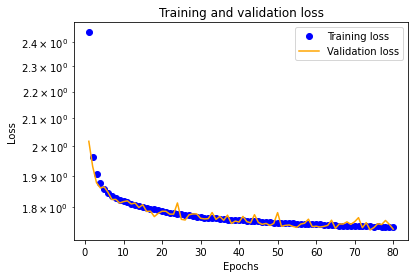

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
#plt.savefig('/home/jieun201/fullprecision400e_yprofile/loss.png')

In [10]:
#model.save('models_1Dy/gausstest.keras')

In [11]:
p_test = model.predict(X_test)
np.savetxt("test_1DyGaus.csv", p_test, delimiter=",")

In [12]:
residuals = y_test - p_test[:,0]

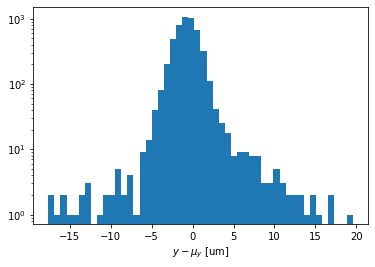

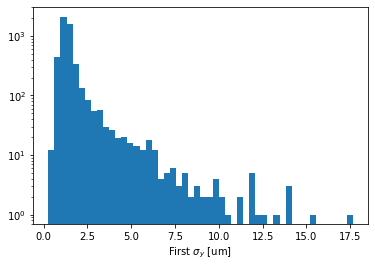

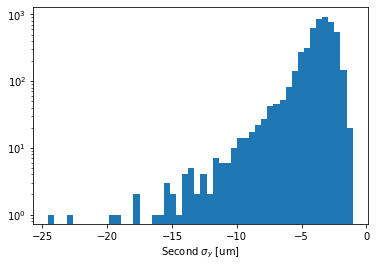

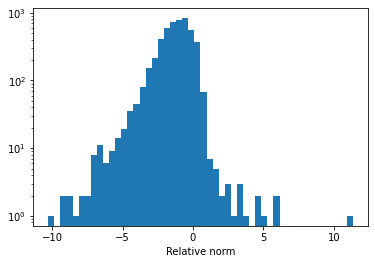

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(p_test[:,1],bins=50);
plt.yscale('Log')
plt.xlabel(r'First $\sigma_y$ [um]')
plt.show()

plt.hist(p_test[:,2],bins=50);
plt.yscale('Log')
plt.xlabel(r'Second $\sigma_y$ [um]')
plt.show()

plt.hist(p_test[:,3],bins=50);
plt.yscale('Log')
plt.xlabel(r'Relative norm')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]

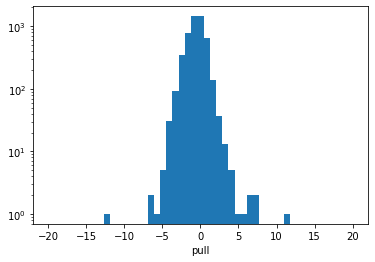

In [15]:
plt.hist(pulls,bins=np.linspace(-20,20,50));
plt.xlabel('pull')
plt.yscale('log')

In [16]:
print(np.mean(pulls),np.std(pulls))

-0.5643700532620276 1.1612817786623448


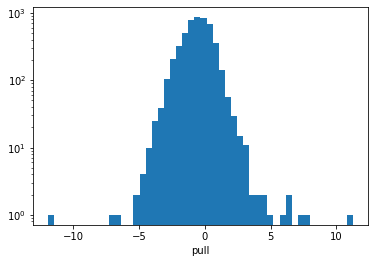

In [17]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')
plt.yscale('log')